In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
import bisect

from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
# 1.Read File

In [3]:
data = pd.read_csv('/Users/check4068/Desktop/Product Sense/4.Identifying Fraudulent Activities/Fraud.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
data.info

<bound method DataFrame.info of         Unnamed: 0  user_id         signup_time       purchase_time  \
0                1    22058 2015-02-24 22:55:49 2015-04-18 02:47:11   
1                2   333320 2015-06-07 20:39:50 2015-06-08 01:38:54   
2                3     1359 2015-01-01 18:52:44 2015-01-01 18:52:45   
3                4   150084 2015-04-28 21:13:25 2015-05-04 13:54:50   
4                5   221365 2015-07-21 07:09:52 2015-09-09 18:40:53   
...            ...      ...                 ...                 ...   
151107      151108   345170 2015-01-27 03:03:34 2015-03-29 00:30:47   
151108      151109   274471 2015-05-15 17:43:29 2015-05-26 12:24:39   
151109      151110   368416 2015-03-03 23:07:31 2015-05-20 07:07:47   
151110      151111   207709 2015-07-09 20:06:07 2015-09-07 09:34:46   
151111      151112   138208 2015-06-10 07:02:20 2015-07-21 02:03:53   

        purchase_value      device_id  source browser sex  age    ip_address  \
0                   34  QVPSPJUOCKZ

In [5]:
address2country = pd.read_csv('/Users/check4068/Desktop/Product Sense/4.Identifying Fraudulent Activities/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


# 2.Merge Two Table

In [6]:
class IpLookupTable(object):
    def __init__(self, df):
        """
        input: 
            df: DataFrame read from 'IpAddress_to_Country.csv'
        """
        self._nrows = df.shape[0]
        # add two more slots, one is for the ipaddress < minimum ipaddress from the file
        # another is for the ipaddress > maximum ipaddress from the file
        self._ip_lowbounds = [0 for _ in range(self._nrows + 2)]
        self._countries = ["Unknown" for _ in range(self._nrows + 2)]

        # start from 1, because 0-th cell is for ipaddress < minimal known ipaddress
        for r in range(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r - 1, 0]
            self._countries[r] = df.iloc[r - 1, 2]
            # assume the file is in ascending order
            assert self._ip_lowbounds[r] > self._ip_lowbounds[r - 1]

        # we cannot assign all ip> last low boundary to be that country
        # so I create a dummy ipaddress which larger than maximal known ipaddress
        self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows - 1, 1] + 1

    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
        # within the range, or in last cell which doesn't have next cell
        assert ip >= self._ip_lowbounds[index] and (index == self._nrows + 1 or ip < self._ip_lowbounds[index + 1])
        return self._countries[index]

In [7]:
iplookuptable = IpLookupTable(address2country)
data["country"] = data.ip_address.map(iplookuptable.find_country)
data

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,151108,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States
151108,151109,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands
151109,151110,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan
151110,151111,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States


# 3.Feature Engineering

In [8]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [9]:
# Check user number for unique devices
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [10]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [11]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [12]:
# how many users are from the same country
n_country_shared = data.country.value_counts()

# the less visit from a country, the more suspicious
data['n_country_shared'] = data.country.map(n_country_shared)
del data['country']

In [13]:
data.head()
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'n_country_shared', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,n_country_shared,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,7918,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,59222,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,59222,1,12,8,1
3,1,18,0,19,44,SEO,Safari,M,41,20017,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,59222,41461,1,1,0


In [14]:
data['is_male'] = (data.sex == 'M').astype(int)
del data['sex']

In [15]:
data = pd.get_dummies(data,columns=['source','browser'])

del data['source_Direct']
del data['browser_Opera']

In [16]:
data.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,age,n_country_shared,time_diff,device_num,ip_num,is_fraud,is_male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
0,1,9,5,16,34,39,7918,13882,1,1,0,1,0,1,1,0,0,0
1,6,23,0,24,16,53,59222,17944,1,1,0,0,1,0,1,0,0,0
2,3,1,3,1,15,53,59222,1,12,8,1,1,0,1,0,0,0,0
3,1,18,0,19,44,41,20017,60085,1,1,0,1,0,1,0,0,0,1
4,1,30,2,37,39,45,59222,41461,1,1,0,1,1,0,0,0,0,1


# 4.Machine Learning

In [17]:
from sklearn.model_selection import train_test_split
X = data.loc[:,data.columns != 'is_fraud']
y = data['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

from sklearn import svm
svm = svm.SVC(kernel='linear', probability=True)

In [21]:
#随机森林
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
scores = cross_val_score(rfc, X_train, y_train, cv=10)
scores

array([0.95301643, 0.9589721 , 0.95456049, 0.95345759, 0.95422962,
       0.95797949, 0.95433991, 0.95234944, 0.9552173 , 0.95334216])

In [22]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

y_pred = log.decision_function(X_test)

In [81]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc = auc(fpr,tpr)


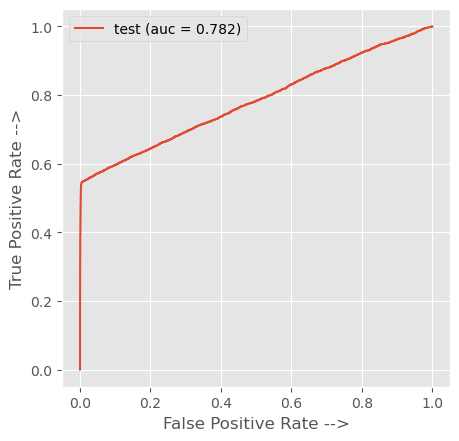

In [82]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, label='test (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()


Problem 2

if false positive cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
if false negative cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

in this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so

if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.
so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.



# 5.Feature Important

In [67]:
# Classification report
from sklearn.metrics import auc, roc_curve, classification_report
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     82107
           1       0.94      0.53      0.68      8560

    accuracy                           0.95     90667
   macro avg       0.95      0.76      0.83     90667
weighted avg       0.95      0.95      0.95     90667



In [68]:
confusion_matrix(y_train, train_pred)

array([[81839,   268],
       [ 4053,  4507]])

In [72]:
feat_importances = pd.DataFrame({"name":X_train.columns,"coef":rfc.feature_importances_})
feat_importances = feat_importances[['name','coef']]# reorder the columns
feat_importances['importances'] = np.abs( feat_importances['coef'] )
feat_importances.sort_values(by="importances",inplace=True,ascending=False)
feat_importances

,name,coef,importances
3,purchase_week,0.233209,0.233209
7,time_diff,0.230953,0.230953
9,ip_num,0.155879,0.155879
1,signup_week,0.071959,0.071959
4,purchase_value,0.064214,0.064214
5,age,0.056073,0.056073
6,n_country_shared,0.041012,0.041012
8,device_num,0.035456,0.035456
2,purchase_day,0.029659,0.029659
0,signup_day,0.028462,0.028462


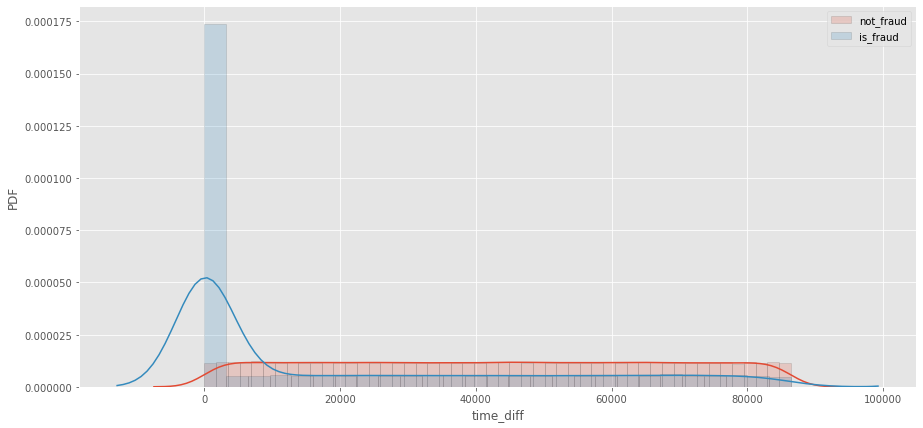

In [77]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data[data['is_fraud']==0]['time_diff'], 
             label='not_fraud', ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['is_fraud']==1]['time_diff'], 
             label='is_fraud', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('time_diff', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()


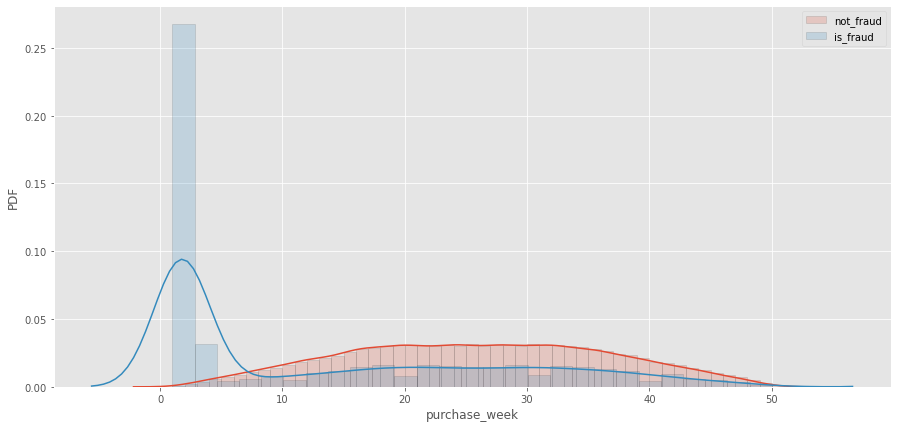

In [78]:
# Visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data[data['is_fraud']==0]['purchase_week'], 
             label='not_fraud', ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['is_fraud']==1]['purchase_week'], 
             label='is_fraud', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('purchase_week', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()


Question 3
 
'Purchase week' and "Time different" is the most important factor. 
Most fraud transaction occur at the beginning of the year and the time difference between sign up and purchase is very low.

Question 4

since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', alert1 and alert2, and alert1 < alert2 .

for a incoming purchase, my model will return the probability 'p' that the purchase is fraud,

if p < alert1, then I assume the purchase is normal, proceed without any problem
if alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
if p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.